## 서울 예측 모델(SimpleRNN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

In [2]:
file_path = "./dataset/seoul_pm10.csv"
data = pd.read_csv(file_path, encoding='cp949')
data.head()

,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.0,44.0
1,2022-12-31 23:00,강동구,68.0,55.0
2,2022-12-31 23:00,강북구,59.0,42.0
3,2022-12-31 23:00,강서구,62.0,40.0
4,2022-12-31 23:00,관악구,57.0,38.0


In [6]:
# 결측치 확인
print(data.isnull().sum())

date        0
area        0
pm10        0
pm2.5    4247
dtype: int64


In [4]:
# 날짜 형식으로 변환
data['date'] = pd.to_datetime(data['date'])
# 날짜순으로 정렬
data = data.sort_values('date')

In [5]:
# 결측치를 평균값으로 대체
mean_value = data['pm10'].mean()
data['pm10'] = data['pm10'].fillna(mean_value)

In [7]:
# 그 다음 target 추출
target = data['pm10'].values

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target.reshape(-1, 1))

In [9]:
# 데이터셋 생성 함수
def create_dataset(dataset, look_back=24):
    X, y = [] , []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back,0])
    return np.array(X), np.array(y)

In [10]:
look_back = 24
X, y = create_dataset(scaled_data, look_back)

In [11]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [12]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
model = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
# from keras.callbacks import EarlyStopping

# # early stopping 추가
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# 모델 훈련
history = model.fit(
    X_train, 
    y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
    # ,
    # callbacks=[early_stopping]
)

Epoch 1/5
1424/1424 [==============================] - 7s 5ms/step - loss: 2.0794e-04 - val_loss: 3.4250e-04
Epoch 2/5
1424/1424 [==============================] - 7s 5ms/step - loss: 2.0609e-04 - val_loss: 3.3738e-04
Epoch 3/5
1424/1424 [==============================] - 7s 5ms/step - loss: 2.0568e-04 - val_loss: 3.5760e-04
Epoch 4/5
1424/1424 [==============================] - 7s 5ms/step - loss: 2.0650e-04 - val_loss: 3.1465e-04
Epoch 5/5
1424/1424 [==============================] - 7s 5ms/step - loss: 2.0553e-04 - val_loss: 3.7151e-04


In [32]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # 정규화 복원

In [33]:
# 실제 값 복원
actual_values = scaler.inverse_transform(y_test.reshape(-1,1))

In [34]:
# 시각화를 위한 날짜 인덱스 만들기
test_dates = data['date'].values[-(len(predictions)):] 

C:\Users\human-14\AppData\Local\Temp\ipykernel_2368\3102825199.py:11: UserWarning: Glyph 13197 (\N{SQUARE MU G}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human-14\AppData\Local\Temp\ipykernel_2368\3102825199.py:11: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Ai_Project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13197 (\N{SQUARE MU G}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Ai_Project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


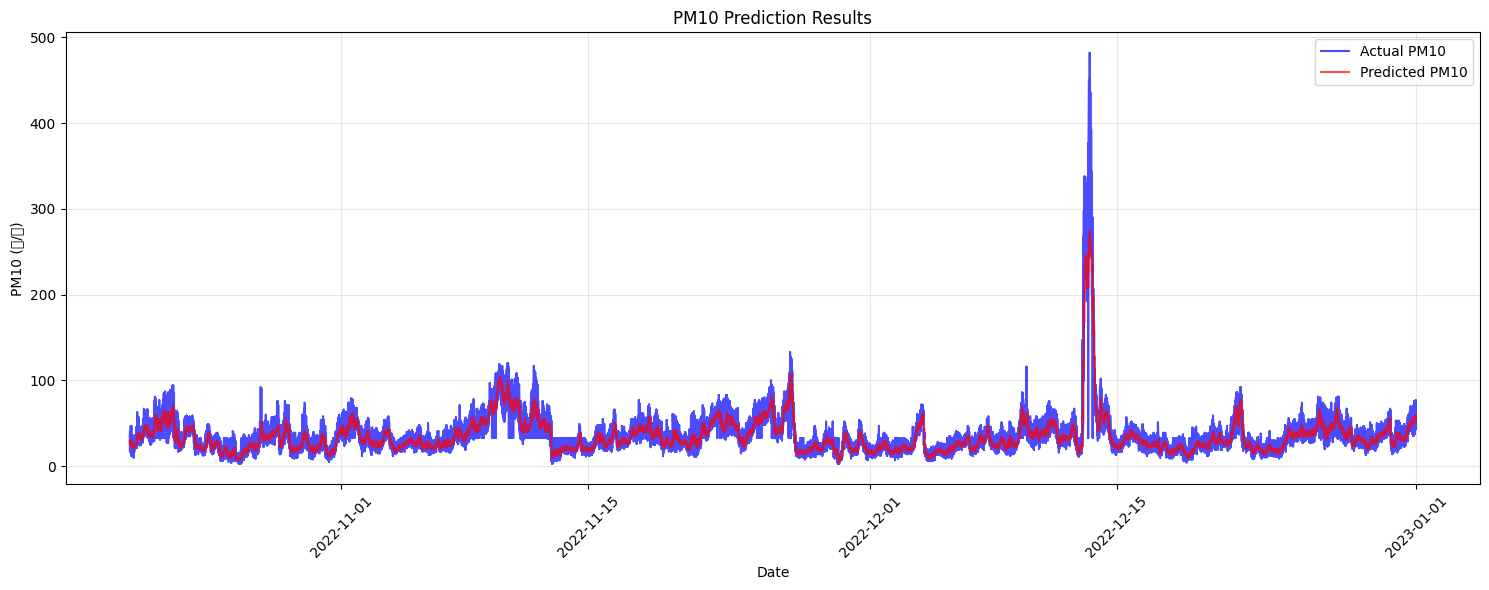

In [35]:
# 시각화
plt.figure(figsize=(15, 6))
plt.plot(test_dates, actual_values, label='Actual PM10', color='blue', alpha=0.7)
plt.plot(test_dates, predictions, label='Predicted PM10', color='red', alpha=0.7)
plt.title('PM10 Prediction Results')
plt.xlabel('Date')
plt.ylabel('PM10 (㎍/㎥)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
# MAE, RMSE 같은 평가 지표도 출력
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 5.27
RMSE: 9.23


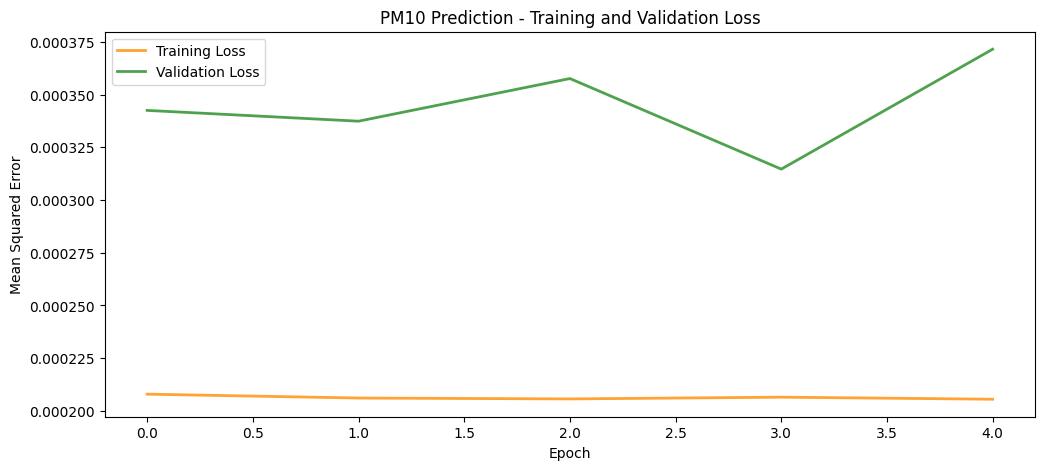

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', color='#FF8C00', linewidth=2, alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#228B22', linewidth=2, alpha=0.8)
plt.title('PM10 Prediction - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [38]:
# 최종 loss 값들 출력
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')

Final Training Loss: 0.0002
Final Validation Loss: 0.0004
